<a href="https://colab.research.google.com/github/ivolake/2021sem9_ml_labs/blob/main/L4_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений
Оригинал: https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_russian/topic03_decision_trees_knn/lesson3_practice_trees_titanic.ipynb

Загрузим библиотеки

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

Вот так выглядят графики критериев информативности $H(X)$

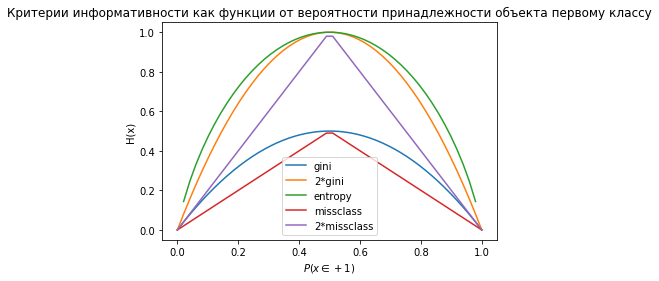

In [ ]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('$P(x \in +1)$')
plt.ylabel('H(x)')
plt.title('Критерии информативности как функции от вероятности принадлежности объекта первому классу')
plt.legend();

#### Пример
Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [ ]:
# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации.

In [ ]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Отобразим данные. Неформально, задача классификации в этом случае – построить какую-то "хорошую" границу, разделяющую 2 класса (красные точки от желтых). Если утрировать, то машинное обучение в этом случае сводится к тому, как выбрать хорошую разделяющую границу. Возможно,  прямая будет слишком простой границей, а какая-то сложная кривая, огибающая каждую красную точку – будет слишком сложной и будем много ошибаться на новых примерах из того же распределения, из которого пришла обучающая выборка. Интуиция подсказывает, что хорошо на новых данных будет работать какая-то *гладкая* граница, разделяющая 2 класса, или хотя бы просто прямая (в $n$-мерном случае - гиперплоскость). 

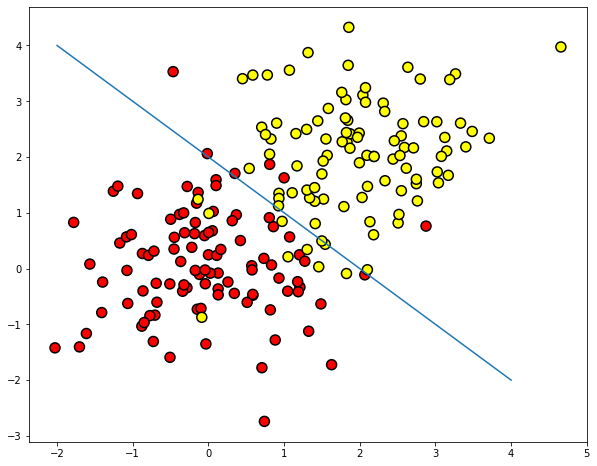

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр `max_depth`, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

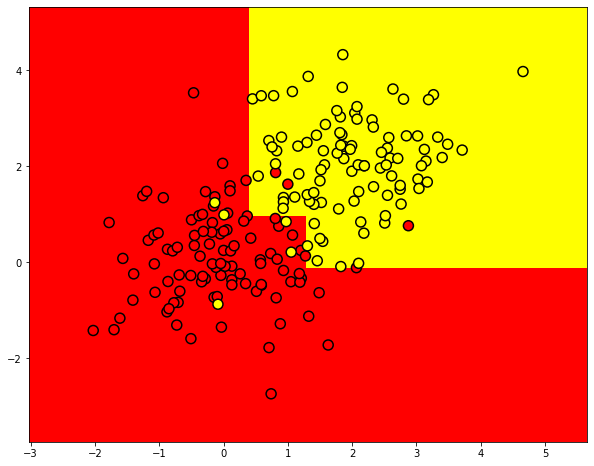

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [ ]:
# установим некоторые пакеты, которые понадобятся для удобного отображения дерева
# чтобы следующий код заработал на винде, нужно установить программулину:
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html

import os
if os.name == 'mac':
    !xcode-select --install
    !/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
    !brew install graphviz

!pip install graphviz
if os.name == 'nt':
    os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

!pip install pydotplus

In [ ]:
# используем .dot формат для визуализации дерева
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

<!-- 
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='../../img/small_tree.dot', filled=True)
!dot -Tpng '../../img/small_tree.dot' -o '../../img/small_tree.png'

<img src='../../img/small_tree.png'> -->

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

In [ ]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [ ]:
data

,Возраст,Невозврат кредита
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Отсортируем ее по возрастанию возраста.

In [ ]:
data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Обучим на этих данных дерево решений (без ограничения глубины) и посмотрим на него.

In [ ]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [ ]:
dot_data = StringIO()
export_graphviz(age_tree, feature_names=['Возраст'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x0c\x00\x00\x03\x07\x08\x06\x00\x00\x00U6\x0fx\x…

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: 43.5, 19, 22.5, 30 и 32 года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с 1 на 0 или наоборот.

Рассмотрим пример посложнее: добавим признак "Зарплата" (тыс. рублей/месяц).

In [ ]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

In [ ]:
data2

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Если отсортировать по возрасту, то целевой класс ("Невозврат кредита") меняется (с 1 на 0 или наоборот) 5 раз. А если отсортировать по зарплате – то 7 раз. Как теперь дерево будет выбирать признаки? Посмотрим.

In [ ]:
data2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [ ]:
data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [ ]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values);

In [ ]:
dot_data = StringIO()
export_graphviz(age_sal_tree, feature_names=['Возраст', 'Зарплата'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x11\x00\x00\x02|\x08\x06\x00\x00\x00@\xf4\xf3\x9…

<!--
export_graphviz(age_sal_tree, feature_names=['Возраст', 'Зарплата'], 
                out_file='../../img/age_sal_tree.dot', filled=True)
!dot -Tpng '../../img/age_sal_tree.dot' -o '../../img/age_sal_tree.png'
<img src='../../img/age_sal_tree.png'>
-->

Видим, что в дереве задействованы как разбиения по возрасту, так и по зарплате. Причем пороги, с которыми сравниваются признаки: 43.5 и 22.5 года – для возраста и 95 и 30.5 тыс. руб/мес – для зарплаты. И опять можно заметить, что 95 тыс. – это среднее между 88 и 102, при этом человек с зарплатой 88 оказался "плохим", а с 102 – "хорошим". То же самое для 30.5 тыс. То есть перебирались сравнения зарплаты и возраста не со всеми возможными значениями, а только с несколькими. А почему в дереве оказались именно эти признаки? Потому что по ним разбиения оказались лучше (по критерию неопределенности Джини).  

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*,  про нее чуть ниже.


## Дерево решений в задаче регрессии
 
 При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества: 
 
 - Дисперсия вокруг среднего: $$H(X) = \frac{1}{|X|} \sum \limits_{i \in X} (y_i - \overline{y}(X))^2 $$
 Минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

#### Пример
Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c некоторым шумом.

In [ ]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

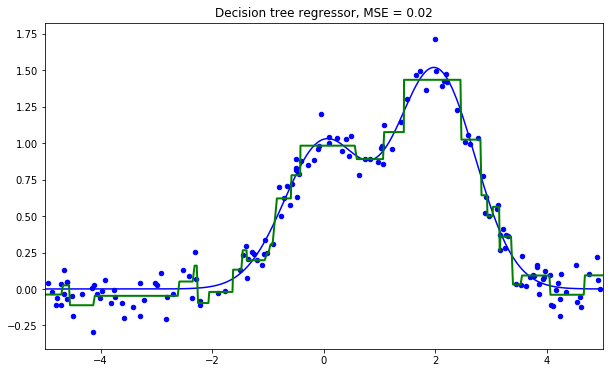

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

Видим, что дерево решений аппроксимирует зависимость в данных кусочно-постоянной функцией. 

### Сложный случай для деревьев
В продолжение обсуждения плюсов и минусов приведем очень простой пример задачи классификации, с которым дерево справляется, но делает все как-то "сложнее", чем хотелось бы. Создадим множество точек на плоскости (2 признака), каждая точка будет относиться к одному из классов (+1, красные, или -1 – желтые). Если смотреть на это как на задачу классификации, то вроде все очень просто – классы разделяются прямой. 

In [ ]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

In [ ]:
X, y = form_linearly_separable_data()

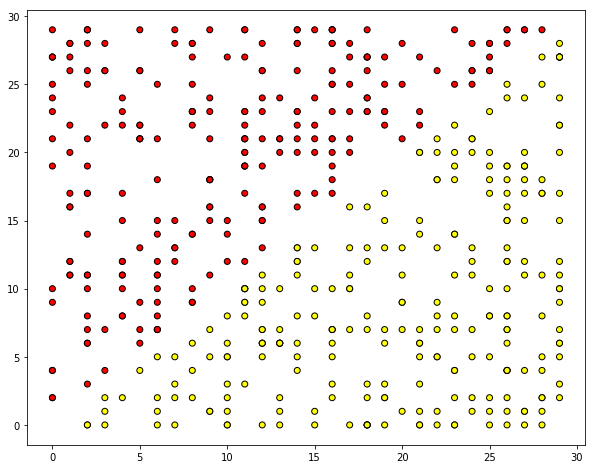

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

Однако дерево решений строит уж больно сложную границу и само по себе оказывается глубоким. Кроме того, представьте, как плохо дерево будет обобщаться на пространство вне представленного квадрата $30 \times 30$, обрамляющего обучающую выборку.

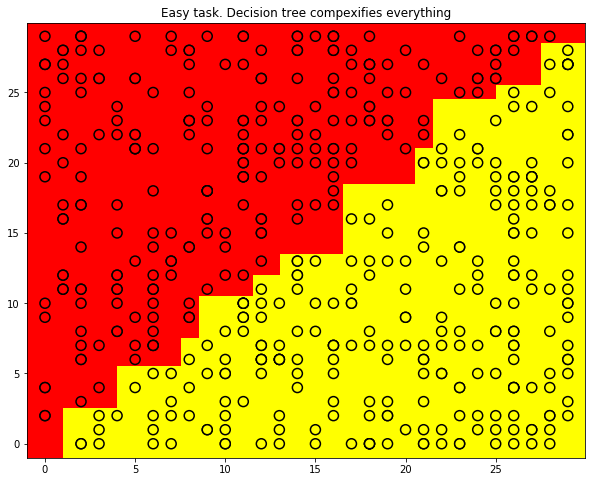

In [ ]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

Вот такая сложная конструкция, хотя решение (хорошая разделяющая поверхность) – это всего лишь прямая $x_1 = x_2$.

In [ ]:
dot_data = StringIO()
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07\x91\x00\x00\x03\x91\x08\x06\x00\x00\x00\xdb\x0bU…

<!--
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file='../../img/deep_toy_tree.dot', filled=True)
!dot -Tpng '../../img/deep_toy_tree.dot' -o '../../img/deep_toy_tree.png'

<img src='../../img/deep_toy_tree.png'>
-->

Метод одного ближайшего соседа здесь справляется вроде лучше дерева, но все же не так хорошо, как линейный классификатор (наша следующая тема).

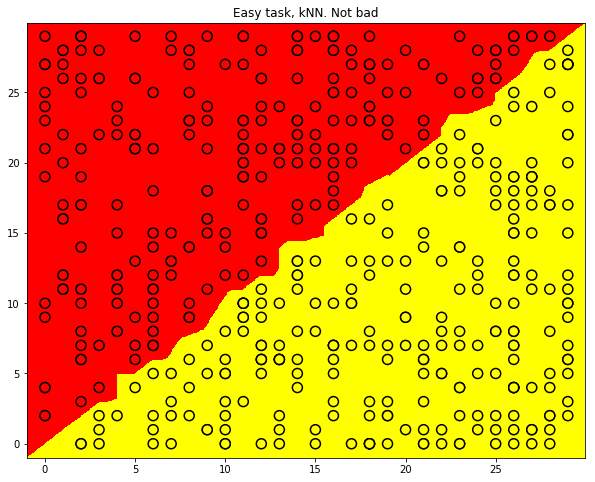

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');